In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print('Gen RAM Free: ' + humanize.naturalsize( psutil.virtual_memory().available ), ' I Proc size: ' + humanize.naturalsize( process.memory_info().rss))
  print('GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB'.format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.4 GB  I Proc size: 131.7 MB
GPU RAM Free: 11439MB | Used: 0MB | Util   0% | Total 11439MB


In [2]:
!git clone --recursive https://github.com/darar1/datasciencebowl2018.git
!wget https://github.com/matterport/Mask_RCNN/archive/master.zip -c
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5 -c
!mkdir mask-rcnn
!unzip -o master.zip -d mask-rcnn/
# Data Path
TRAIN_PATH = 'datasciencebowl2018/stage1_training/'
TEST_PATH = 'datasciencebowl2018/stage1_testing/'
!ls

fatal: destination path 'datasciencebowl2018' already exists and is not an empty directory.
--2018-03-16 06:53:22--  https://github.com/matterport/Mask_RCNN/archive/master.zip
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/matterport/Mask_RCNN/zip/master [following]
--2018-03-16 06:53:22--  https://codeload.github.com/matterport/Mask_RCNN/zip/master
Resolving codeload.github.com (codeload.github.com)... 192.30.253.120, 192.30.253.121
Connecting to codeload.github.com (codeload.github.com)|192.30.253.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [     <=>            ]  36.80M  23.5MB/s    in 1.6s    

2018-03-16 06:53:25 (23.5 MB/s) - ‘master.zip’ saved [38590409]

--2018-03-16 06:53:25--  https://gi


  inflating: mask-rcnn/Mask_RCNN-master/inspect_weights.ipynb  
  inflating: mask-rcnn/Mask_RCNN-master/model.py  
  inflating: mask-rcnn/Mask_RCNN-master/parallel_model.py  
  inflating: mask-rcnn/Mask_RCNN-master/shapes.py  
  inflating: mask-rcnn/Mask_RCNN-master/train_shapes.ipynb  
  inflating: mask-rcnn/Mask_RCNN-master/utils.py  
  inflating: mask-rcnn/Mask_RCNN-master/visualize.py  
datalab		     mask_rcnn_coco.h5	test_size.npy
datasciencebowl2018  master.zip		train_img.npy
mask-rcnn	     test_img.npy	train_mask.npy


In [3]:
# Downloading and intstalling keras
!pip install keras

import sys
sys.path.insert(0, 'mask-rcnn/Mask_RCNN-master')
from config import Config
import utils
import model as modellib
import visualize
from model import log
import os
import random
import warnings
import numpy as np
import pandas as pd
import math
from itertools import chain
from skimage.util import img_as_ubyte
from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from skimage import transform
from skimage.morphology import label
import matplotlib.pyplot as plt
from keras.utils import Progbar
from google.colab import files
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


Using TensorFlow backend.


In [0]:
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
ignore_masks = ["ee43930956917b35e8ea9950119904ee43eeaf297ae2d0999a96bce06465119b.png", 
                "976fdddb84f5e86cc06b746252d103836124a0b0fa01865652789ee3ae1ebec0.png", 
                "e512fabd19592b09562cfabb45b7c3bff574d1f6818b7b53b5fede10016dc8b2.png", 
                "b82e80e4f8190720f38ea3fab4a05f133fd862b592db9ffd73f630500c7f94fb.png", 
                "879eb8b1875444d0f9e42755b1007978f9c3706285e862c7c42bf4900d1a5c1f.png", 
                "4713d7309386224347ea05586644b2fad515c272463c1662236109d1755191d9.png", 
                "493e574250a73120c05755367a2d032940563fdad88451d3ac42703fa93e1f8e.png", 
                "7ac528af7d96b1bae71a3b07d3f8de6dcde063c3dc2a84500fae46e46cd76bc6.png", 
                "777459648d2c4c18fe8df79e284fbec4decc5f3ffaf26930ec7d3d457b84ae62.png", 
                "9551f2dad01c71f81d5e2386a99bc963457338d0c79fda0e90e9226f50b5dada.png", 
                "069acba0cce8b22a267edd80e6c4303d9f8dd980bdcea0cf2569079b02cf6b41.png", 
                "4cff40e93297cd84240c4e05d861efc4c6c8ad6cab073968e75fea862639439e.png", 
                "2ec5a0547b47b663b91224a0b0b031ba26c6d81dd8c2271a0142ff50e7a3c90e.png", 
                "e707c768392b287baffc9307f2dc0d6a9993e40bcae8945caf0925bc789e4259.png", 
                "cd443eb126f389fb815a24b65035b306268bcfc3b4ad077c58110c5c1255805b.png", 
                "b9a160bc22b20d83a529f71b75f8ac11bed4f306c3d02d3d5496cefcda91666a.png", 
                "1f06b1d1ef191b4a0ecf28636d017d143114ac3e4760f0eb35f56af006d41a62.png", 
                "e969172b62b37ba15754478b69cefce1bf61534b46b4ac9e80e07a410815cfdc.png", 
                "0a0cb3d0373050e8f63302c2c1ab79c9a35249e98dda568418e79222eb9beb6f.png"]

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [6]:
class NucleiConfig(Config):
  """Configuration for training on the toy shapes dataset.
  Derives from the base Config class and overrides values specific
  to the toy shapes dataset.
  """
  # Give the configuration a recognizable name
  NAME = "nuclei"

  # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
  # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
  GPU_COUNT = 1
  IMAGES_PER_GPU = 2

  # Number of classes (including background)
  NUM_CLASSES = 1 + 1  # background + nuclei

  # Use small images for faster training. Set the limits of the small side
  # the large side, and that determines the image shape.
  IMAGE_MIN_DIM = 256
  IMAGE_MAX_DIM = 256

  # Use smaller anchors because our image and objects are small
  RPN_ANCHOR_SCALES = (4,8,16,32,64)  # anchor side in pixels

  # Reduce training ROIs per image because the images are small and have
  # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
  TRAIN_ROIS_PER_IMAGE = 500
  
  MEAN_PIXEL = [0, 0, 0]
  
  DETECTION_MAX_INSTANCES = 128
  
  STEPS_PER_EPOCH = 600
  LEARNING_RATE = 0.001
  WEIGHT_DECAY = 0.0001
  USE_MINI_MASK = True
  MAX_GT_INSTANCES = 500
  VALIDATION_STEPS = 70
    
config = NucleiConfig()
config.display()

class NucleiDataset(utils.Dataset):
  
    def load_nuclei(self, dataset, width, height):
      self.add_class("nuclei", 1, "nucleus")
      self.add_class("nuclei", 2, "background")
      
      train_dir = TRAIN_PATH
      
      listdir = os.listdir(train_dir)
      if dataset == "train":
        listdir = listdir[:570]
      elif dataset == "val":
        listdir = listdir[571:]
      for i,file in enumerate(listdir):
        self.add_image("nuclei", image_id=i, path=file, width=width, height=height)   
  
    def load_image(self, image_id):
      info = self.image_info[image_id]
      image_path = info["path"]
      full_path = "datasciencebowl2018/stage1_training/%s/images/%s.png" % (image_path, image_path)
      image = imread(full_path)[:,:,:3]
      image = transform.resize(image, (256, 256))
      return image

    def image_reference(self, image_id):
      return image_id

    def load_mask(self, image_id):
      info = self.image_info[image_id]
      image_path = info["path"]
      mask_dir = "datasciencebowl2018/stage1_training/%s/masks/" % (image_path)

      mask_ldir = os.listdir(mask_dir)
      mask = np.zeros((256, 256, len(mask_ldir)))
      
      counter = 0
      for file in mask_ldir:
        if file in ignore_masks:
          continue
        mask_path = mask_dir + file
        loaded_mask = imread(mask_path)
        loaded_mask = transform.resize(loaded_mask, (256, 256))
        if np.count_nonzero(loaded_mask) == 0:
          continue
        else:
          mask[:,:,counter] = loaded_mask
          counter+=1
      
      mask = mask[:,:,0:counter]

      class_ids = np.array([1 for _ in range(np.size(mask, 2))])
      return mask, class_ids.astype(np.int32)


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        128
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               500
MEAN_PIXEL                     [0, 0, 0]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_POSITIVE_R

In [7]:
!ls

datalab		     mask_rcnn_coco.h5	test_size.npy
datasciencebowl2018  master.zip		train_img.npy
mask-rcnn	     test_img.npy	train_mask.npy


In [8]:
!rm datasciencebowl2018/stage1_training/.DS_Store/images/.DS_Store.png
# Training dataset
dataset_train = NucleiDataset()
dataset_train.load_nuclei('train',256,256)
dataset_train.prepare()

# Testing dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei('val',256,256)
dataset_val.prepare()

os.name = "nt"

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir="")

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
  model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
  # Load weights trained on MS COCO, but skip layers that
  # are different due to the different number of classes
  # See README for instructions to download the COCO weights
  model.load_weights("mask_rcnn_coco.h5", by_name=True,
                     exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                              "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
  # Load the last model you trained and continue training
  model.load_weights(model.find_last()[1], by_name=True)

elif init_with == "self":
  #file_id = '1LqofnpPDIySZE-oa62EFhkDSg1RM6HXy'
  downloaded = drive.CreateFile({'mask_rcnn_coco': mask_rcnn_coco.h5})
  downloaded.GetContentFile('mask_rcnn_coco.h5')
  model.load_weights('mask_rcnn_coco.h5')
!ls
'''
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")
'''
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=2, 
            layers='heads')

model.keras_model.save_weights("mask_rcnn_coco.h5")

rm: cannot remove 'datasciencebowl2018/stage1_training/.DS_Store/images/.DS_Store.png': Not a directory
datalab		     mask_rcnn_coco.h5	test_size.npy
datasciencebowl2018  master.zip		train_img.npy
mask-rcnn	     test_img.npy	train_mask.npy

Starting at epoch 0. LR=0.001

Checkpoint Path: nuclei20180316T0658/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mr

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2
222/600 [==========>...................] - ETA: 16:05 - loss: 3.6184 - rpn_class_loss: 0.4400 - rpn_bbox_loss: 1.6258 - mrcnn_class_loss: 0.1200 - mrcnn_bbox_loss: 0.7404 - mrcnn_mask_loss: 0.6922

ERROR:root:Error processing image {'id': 52, 'source': 'nuclei', 'path': '.DS_Store', 'width': 256, 'height': 256}
Traceback (most recent call last):
  File "mask-rcnn/Mask_RCNN-master/model.py", line 1637, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "mask-rcnn/Mask_RCNN-master/model.py", line 1190, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-6-1b69eee569d6>", line 63, in load_image
    image = imread(full_path)[:,:,:3]
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 61, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 211, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/pil_plugin.py", line 35, in imread
    with open(fname, 'rb') as f:
NotADirectoryError: [Errno 20] Not a directory: 'datasciencebowl2018/stage1_training/.DS_Sto

454/600 [=====================>........] - ETA: 6:05 - loss: 3.4153 - rpn_class_loss: 0.3552 - rpn_bbox_loss: 1.5799 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.7067 - mrcnn_mask_loss: 0.6615

ERROR:root:Error processing image {'id': 52, 'source': 'nuclei', 'path': '.DS_Store', 'width': 256, 'height': 256}
Traceback (most recent call last):
  File "mask-rcnn/Mask_RCNN-master/model.py", line 1637, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "mask-rcnn/Mask_RCNN-master/model.py", line 1190, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-6-1b69eee569d6>", line 63, in load_image
    image = imread(full_path)[:,:,:3]
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 61, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 211, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/pil_plugin.py", line 35, in imread
    with open(fname, 'rb') as f:
NotADirectoryError: [Errno 20] Not a directory: 'datasciencebowl2018/stage1_training/.DS_Sto

600/600 [==============================] - 1502s 3s/step - loss: 3.3545 - rpn_class_loss: 0.3394 - rpn_bbox_loss: 1.5584 - mrcnn_class_loss: 0.1145 - mrcnn_bbox_loss: 0.6938 - mrcnn_mask_loss: 0.6484 - val_loss: 3.0244 - val_rpn_class_loss: 0.1467 - val_rpn_bbox_loss: 1.5650 - val_mrcnn_class_loss: 0.0560 - val_mrcnn_bbox_loss: 0.6691 - val_mrcnn_mask_loss: 0.5876
Epoch 2/2
123/600 [=====>........................] - ETA: 20:03 - loss: 3.2054 - rpn_class_loss: 0.2976 - rpn_bbox_loss: 1.5462 - mrcnn_class_loss: 0.1200 - mrcnn_bbox_loss: 0.6551 - mrcnn_mask_loss: 0.5864

199/600 [========>.....................] - ETA: 17:00 - loss: 3.1592 - rpn_class_loss: 0.2934 - rpn_bbox_loss: 1.5148 - mrcnn_class_loss: 0.1252 - mrcnn_bbox_loss: 0.6500 - mrcnn_mask_loss: 0.5758

ERROR:root:Error processing image {'id': 52, 'source': 'nuclei', 'path': '.DS_Store', 'width': 256, 'height': 256}
Traceback (most recent call last):
  File "mask-rcnn/Mask_RCNN-master/model.py", line 1637, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "mask-rcnn/Mask_RCNN-master/model.py", line 1190, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-6-1b69eee569d6>", line 63, in load_image
    image = imread(full_path)[:,:,:3]
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 61, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 211, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/pil_plugin.py", line 35, in imread
    with open(fname, 'rb') as f:
NotADirectoryError: [Errno 20] Not a directory: 'datasciencebowl2018/stage1_training/.DS_Sto

383/600 [==================>...........] - ETA: 9:03 - loss: 3.0805 - rpn_class_loss: 0.2754 - rpn_bbox_loss: 1.4622 - mrcnn_class_loss: 0.1244 - mrcnn_bbox_loss: 0.6506 - mrcnn_mask_loss: 0.5678

ERROR:root:Error processing image {'id': 52, 'source': 'nuclei', 'path': '.DS_Store', 'width': 256, 'height': 256}
Traceback (most recent call last):
  File "mask-rcnn/Mask_RCNN-master/model.py", line 1637, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "mask-rcnn/Mask_RCNN-master/model.py", line 1190, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-6-1b69eee569d6>", line 63, in load_image
    image = imread(full_path)[:,:,:3]
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py", line 61, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py", line 211, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/pil_plugin.py", line 35, in imread
    with open(fname, 'rb') as f:
NotADirectoryError: [Errno 20] Not a directory: 'datasciencebowl2018/stage1_training/.DS_Sto

600/600 [==============================] - 1495s 2s/step - loss: 3.0666 - rpn_class_loss: 0.2746 - rpn_bbox_loss: 1.4578 - mrcnn_class_loss: 0.1197 - mrcnn_bbox_loss: 0.6518 - mrcnn_mask_loss: 0.5627 - val_loss: 2.8612 - val_rpn_class_loss: 0.1304 - val_rpn_bbox_loss: 1.4572 - val_mrcnn_class_loss: 0.0561 - val_mrcnn_bbox_loss: 0.6952 - val_mrcnn_mask_loss: 0.5222


In [9]:
from google.colab import files

files.download('mask_rcnn_coco.h5')

MessageError: ignored

In [0]:
# Training dataset
dataset_train = NucleiDataset()
dataset_train.load_nuclei('train',256,256)
dataset_train.prepare()

# Testing dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei('val',256,256)
dataset_val.prepare()

original_image           shape: (256, 256, 3)         min:    0.00000  max:    0.84755
image_meta               shape: (11,)                 min:    0.00000  max:  256.00000
gt_class_id              shape: (21,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (21, 4)               min:    0.00000  max:  256.00000
gt_mask                  shape: (256, 256, 21)        min:    0.00000  max:    1.00000


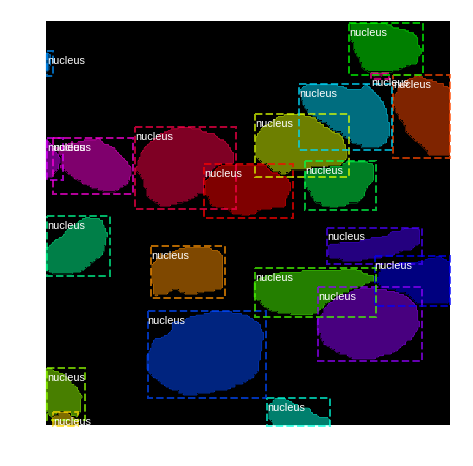


Getting and resizing test images ... 
Test file loaded from memory


In [16]:
from skimage.transform import resize
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir="")


# Load trained weights (fill in path to trained weights here)
model_path = "mask_rcnn_coco.h5"
model.load_weights(model_path, by_name=True)

# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

#results = model.detect([original_image], verbose=1)

#r = results[0]
#visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            #dataset_val.class_names, r['scores'], ax=get_ax())
#print(r)
#imshow(np.shape(r['masks'])[2])
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)
# Iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage
def mask_to_rle(preds_test_upsampled):
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(test_ids):
        rle = list(prob_to_rles(preds_test_upsampled[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    return new_test_ids,rles
# Function to read test images and return as numpy array
def read_test_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    print('\nGetting and resizing test images ... ')
    sys.stdout.flush()
    if os.path.isfile("test_img.npy") and os.path.isfile("test_size.npy"):
        print("Test file loaded from memory")
        X_test = np.load("test_img.npy")
        sizes_test = np.load("test_size.npy")
        return X_test,sizes_test
    b = Progbar(len(test_ids))
    for n, id_ in enumerate(test_ids):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img
        b.update(n)
    np.save("test_img",X_test)
    np.save("test_size",sizes_test)
    return X_test,sizes_test
  
test_img, test_img_sizes = read_test_data()

In [0]:
from tqdm import tqdm
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
new_test_ids = []
rles = []
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')
#transformed_input_data = [[x] for x in input_data]
transformed_input_data = [[x] for x in X_test]
print(len(transformed_input_data)) # changed
#results = model.detect([original_image], verbose=1)
preds_test = model.detect(transformed_input_data, verbose=1)
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [23]:
print("Predicting")
#Create list of upsampled test masks
new_test_ids=[]
test_mask_upsampled= []
rles=[]
for n, image in enumerate(test_ids):
  inp_image = imread("datasciencebowl2018/stage1_testing/" + image + "/images/" + image + ".png")[:,:,:3]
  orig_shape = np.shape(inp_image)
  inp_image = transform.resize(inp_image, (256, 256))
  test_mask = model.detect([inp_image], verbose=1)
  
  r = test_mask[0]
  print(r)
  mask_list = []
  mask_sum = np.zeros((256,256))
  for i in range(np.shape(r['masks'])[2]):
    ind_x, ind_y = np.nonzero(r['masks'][:,:,i])
    mask_sum[ind_x,ind_y] = i
  
  for i in range(np.shape(r['masks'])[2]):
    ind_x,ind_y = np.where(mask_sum==i)
    mask = np.zeros((256,256))
    mask[ind_x,ind_y] = 1
    mask = transform.resize(mask, (list(orig_shape)[0],list(orig_shape)[1]))
    mask_list.append(mask)
    test_mask_upsampled.append(mask)
    #print (mask_list)
   
  for i in range(1,np.shape(r['masks'])[2]):
    #test_ids, rles = mask_to_rle(mask_list)
    rle = list(prob_to_rles(mask_list[i]))
    rles.extend(rle)
    #new_test_ids.extend(test_ids)
    new_test_ids.extend([image] * len(rle))
  '''
  for i in range(np.shape(r['masks'])[2]):
      test_mask_upsampled.append(resize(list(orig_shape)[0],
                                        (256,256)))
  '''


Predicting
Processing 1 images
image                    shape: (256, 256, 4)         min:    0.00000  max:    1.00000


ValueError: ignored

In [20]:
test_ids1, rles1 = mask_to_rle(test_mask_upsampled)
print (test_ids1)
#print (new_test_ids)
#print (rles)
print (rles1)
print (test_mask_upsampled)

#test_ids, rles = mask_to_rle(test_mask_upsampled)
'''
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('DR-dsbowl2018-RCNN.csv', index=False)
uploaded = drive.CreateFile({'DR-dsbowl2018-RCNN': 'DR-dsbowl2018-RCNN.csv'})
uploaded.SetContentFile('DR-dsbowl2018-RCNN.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))
#!ls


uploaded = drive.CreateFile({'mask_rcnn_coco': 'mask_rcnn_coco.h5'})
uploaded.SetContentFile('mask_rcnn_coco.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))
'''

['4f949bd8d914bbfa06f40d6a0e2b5b75c38bf53dbcbafc48c97f105bee4f8fac', '0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac', '4be73d68f433869188fe5e7f09c7f681ed51003da6aa5d19ce368726d8e271ee']
[[1, 93210], [1, 361920], [1, 65536]]


[array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0.

"\nsub = pd.DataFrame()\nsub['ImageId'] = new_test_ids\nsub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))\nsub.to_csv('DR-dsbowl2018-RCNN.csv', index=False)\nuploaded = drive.CreateFile({'DR-dsbowl2018-RCNN': 'DR-dsbowl2018-RCNN.csv'})\nuploaded.SetContentFile('DR-dsbowl2018-RCNN.csv')\nuploaded.Upload()\nprint('Uploaded file with ID {}'.format(uploaded.get('id')))\n#!ls\n\n\nuploaded = drive.CreateFile({'mask_rcnn_coco': 'mask_rcnn_coco.h5'})\nuploaded.SetContentFile('mask_rcnn_coco.h5')\nuploaded.Upload()\nprint('Uploaded file with ID {}'.format(uploaded.get('id')))\n"